**This project explores the application of XGBoost, an advanced machine learning algorithm based on gradient boosting, for stock price forecasting. The dataset used consists of stock price data spanning 4.5 years. After preprocessing and feature engineering, the model was trained to learn patterns and trends from the historical data. Using the trained model, stock price predictions were generated for a future time horizon of 0.5 years (6 months).**

**The objective of this project was to leverage XGBoost's ability to handle complex patterns, its flexibility with feature inclusion, and its efficiency in building accurate and robust predictive models. The performance of XGBoost was evaluated against established time series forecasting benchmarks to assess its suitability for financial market predictions.**

Import Libraries

In [ ]:
pip install scikit-learn==1.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 79.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.3.0 which is incompatible.


In [1]:
import xgboost
import sklearn
print("XGBoost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)

XGBoost version: 2.1.3
scikit-learn version: 1.3.0


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



Connecting to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/TSLA.csv'

Reading Data

In [5]:
data = pd.read_csv(path)
start_date = '2015-01-01'
end_date = '2020-12-31'
data_1 = data[(data['Date']>= start_date) & (data['Date']<= end_date)]
df = data_1[['Date','Adj Close']]
df.head()
df.tail()

,Date,Adj Close
2642,2020-12-24,661.770020
2643,2020-12-28,663.690002
2644,2020-12-29,665.989990
2645,2020-12-30,694.780029
2646,2020-12-31,705.669983


Adding Features

In [6]:
df['lag_1'] = df['Adj Close'].shift(1)
df['lag_2'] = df['Adj Close'].shift(2)
df['lag_5'] = df['Adj Close'].shift(5)
df['moving_avg_5'] = df['Adj Close'].rolling(window=5).mean()
df['moving_avg_20'] = df['Adj Close'].rolling(window=20).mean()
df['return'] = df['Adj Close'].pct_change()
df['volatility'] = df['return'].rolling(window=5).std()
df.dropna(inplace=True)
df.head()

,Date,Adj Close,lag_1,lag_2,lag_5,moving_avg_5,moving_avg_20,return,volatility
1155,2015-01-30,40.720001,41.040001,39.874001,40.257999,40.828001,40.6511,-0.007797,0.025514
1156,2015-02-02,42.188000,40.720001,41.040001,41.310001,41.003600,40.5674,0.036051,0.028064
1157,2015-02-03,43.672001,42.188000,40.720001,41.195999,41.498801,40.6501,0.035176,0.030613
1158,2015-02-04,43.709999,43.672001,42.188000,39.874001,42.266000,40.7228,0.000870,0.020638
1159,2015-02-05,44.198002,43.709999,43.672001,41.040001,42.897601,40.8232,0.011165,0.019901


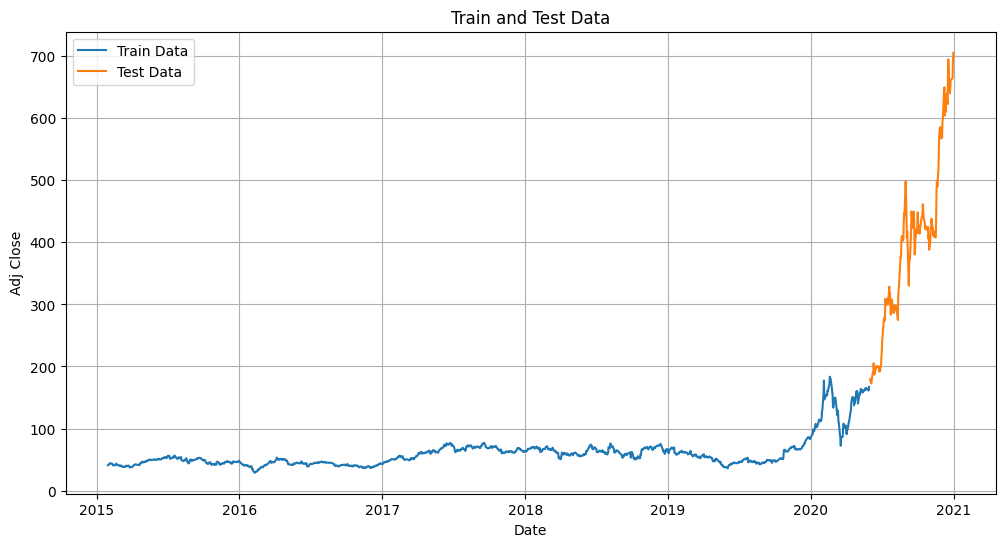

In [7]:
train_data = df[:int(0.9*len(df))]
test_data = df[int(0.9*len(df)):]
train_data.index = pd.to_datetime(train_data['Date'])
test_data.index = pd.to_datetime(test_data['Date'])
plt.figure(figsize=(12,6))
plt.plot(train_data['Adj Close'], label='Train Data')
plt.plot(test_data['Adj Close'], label='Test Data')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.grid(True)
plt.show()

Training and Test Data Spilting

In [8]:
X_train = train_data[['lag_1', 'lag_2','lag_5', 'moving_avg_5','moving_avg_20','return', 'volatility']]
y_train = train_data['Adj Close']

Model Training

In [18]:
xgb_model = XGBRegressor(objective='reg:squarederror')

param_distributions = {
    'n_estimators': [50, 100, 300, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

tscv = TimeSeriesSplit(n_splits=5)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Caluclating Metrics

In [23]:
X_test = test_data[['lag_1', 'lag_2','lag_5', 'moving_avg_5','moving_avg_20','return', 'volatility']]
y_test = test_data['Adj Close']
y_pred_test = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
print('Mean Squared Error:', mse)
mae = np.mean(np.abs(y_test - y_pred_test))
print('Mean Absolute Error:', mae)
r2 = r2_score(y_test, y_pred_test)
print('R-squared:', r2)
rmse = np.sqrt(mse)
print('Root Mean Squared Error:', rmse)


Mean Squared Error: 71500.63549908152
Mean Absolute Error: 229.36922496913414
R-squared: -2.789803097363215
Root Mean Squared Error: 267.39602745568516


Vizualizing the Performance

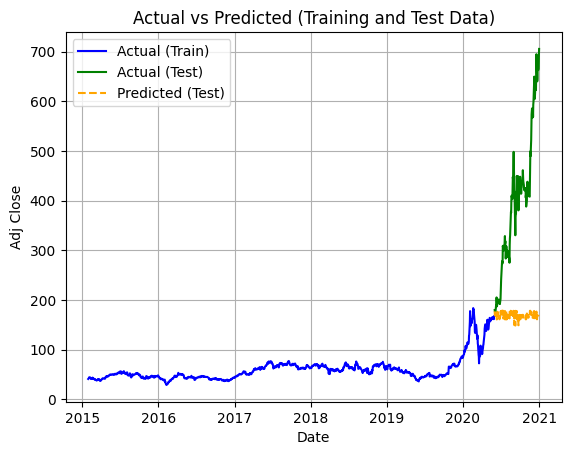

In [22]:
plt.plot(y_train.index, y_train, label='Actual (Train)', color='blue')
#plt.plot(y_train.index, y_pred_train, label='Predicted (Train)', color='red', linestyle='--')

# Plot for test data
plt.plot(y_test.index, y_test, label='Actual (Test)', color='green')
plt.plot(y_test.index, y_pred_test, label='Predicted (Test)', color='orange', linestyle='--')

plt.title('Actual vs Predicted (Training and Test Data)')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.grid(True)
plt.show()

Feature Importance

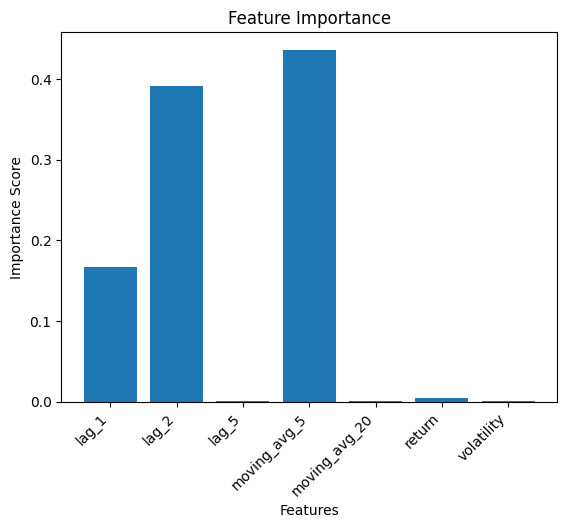

In [21]:
     feature_importances = best_model.feature_importances_
     feature_names = X_train.columns

     plt.bar(feature_names, feature_importances)
     plt.xticks(rotation=45, ha='right')
     plt.xlabel('Features')
     plt.ylabel('Importance Score')
     plt.title('Feature Importance')
     plt.show()

In [ ]:
predicted_df = pd.DataFrame({'Date': test_data['Date'], 'Actual': y_test, 'Predicted': y_pred_test})
predicted_df.to_csv('/content/drive/MyDrive/predicted_values.csv', index=False)
print("Predicted values saved to: /content/drive/MyDrive/predicted_values.csv")

Predicted values saved to: /content/drive/MyDrive/predicted_values.csv


In [ ]:
print(predicted_df.index)

DatetimeIndex(['2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=150, freq=None)
